In [1]:
import sys
sys.path.append("..")
from architecture import VGG16_BN

import torch
import numpy as np


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# load best model's parameter
model = VGG16_BN()
checkpoint = torch.load('./vgg16_baseline_exp3/checkpoint/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

In [4]:
for param in model.parameters() :
    print(param.shape)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512,

# what is the convnet filter? (check the architecture)
![](./vgg16_architecture.png)

# #Maps, #Params, #FLOPs function definition

* FLOP operator reference : https://pypi.org/project/flopth/
* `usage` : 
   * file path : /tmp/my_model.py
   * model name : MyModel
     * `command` : **flopth -m MyModel -p /tmp/my_model -i 3 224 224**

In [5]:
def numMapsParams(_model) :
    # the number of maps
    num_maps = []
    num_params = []
    for param in _model.parameters() :
        # conv layer weight's the number of maps, the number of params
        if len(param.shape) == 4 : 
            num_maps.append(param.shape[0])
            num_params.append(param.shape[0] * param.shape[1] * param.shape[2] * param.shape[3])
        # fc layer weight's the number of maps
        elif len(param.shape) == 2 :
            num_maps.append(param.shape[0])
            num_params.append(param.shape[0] * param.shape[1])
                
            
    return num_maps, num_params 

# #Maps, #Params, #FLOPs before pruning
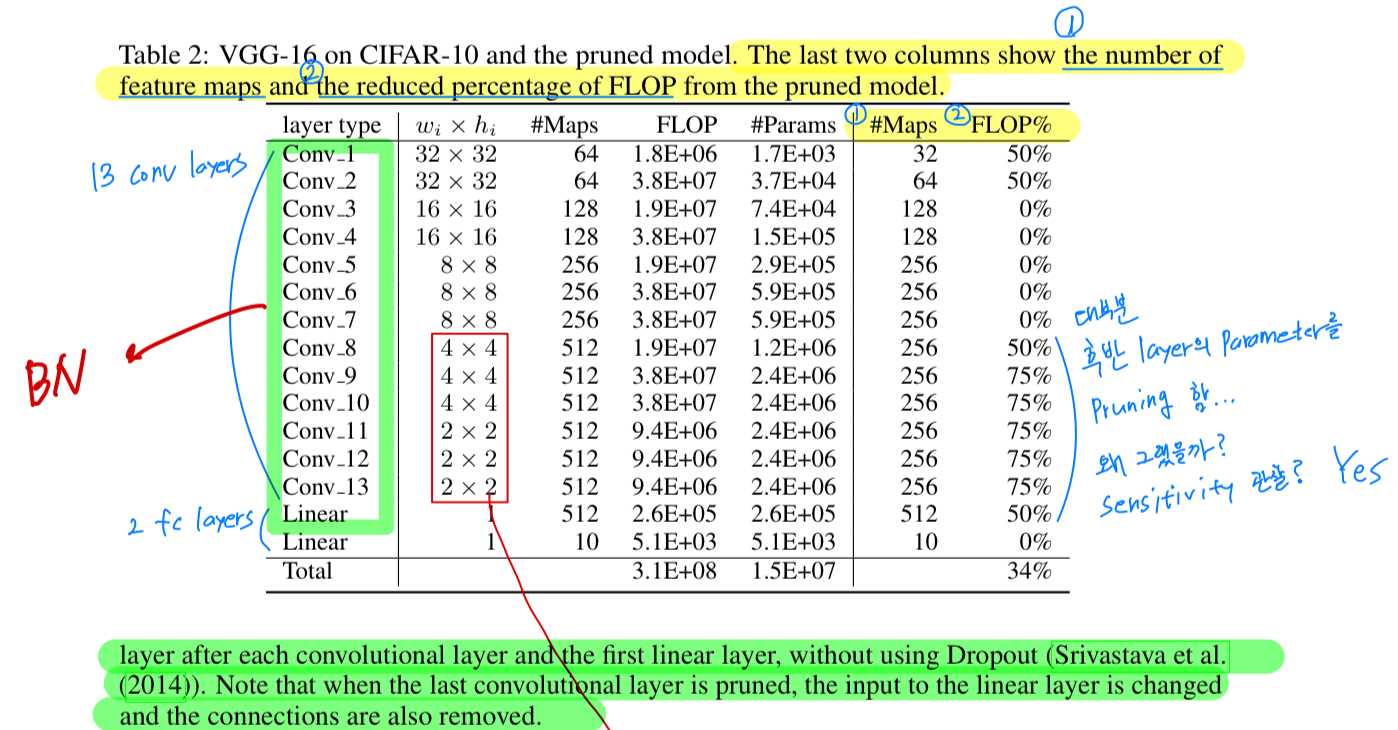

In [6]:
before_num_maps, before_num_params = numMapsParams(model)
before_num_params = [f"{formatted:.1e}" for formatted in before_num_params]

print(f"the number of maps before pruning : {before_num_maps}")
print(f"the number of params before pruning : {before_num_params}")

the number of maps before pruning : [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512, 512, 10]
the number of params before pruning : ['1.7e+03', '3.7e+04', '7.4e+04', '1.5e+05', '2.9e+05', '5.9e+05', '5.9e+05', '1.2e+06', '2.4e+06', '2.4e+06', '2.4e+06', '2.4e+06', '2.4e+06', '2.6e+05', '5.1e+03']


In [7]:
print("the number of flops before pruning")
! flopth -m VGG16_BN -p ./architecture -i 3 32 32

the number of flops before pruning
Op Flatten is not supported at now, set FLOPs of it to zero.
+----------------+---------------+-------------+-------------+------------------------------+----------+------------------+----------------------+----------+-----------------+---------------------+
| module_name    | module_type   | in_shape    | out_shape   | kernel_size,padding,stride   | params   | params_percent   | params_percent_vis   | flops    | flops_percent   | flops_percent_vis   |
+================+===============+=============+=============+==============================+==========+==================+======================+==========+=================+=====================+
| conv_layers.0  | Conv2d        | (3,32,32)   | (64,32,32)  | k=(3, 3), p=(1, 1), s=(1, 1) | 1.792K   | 0.0119531%       |                      | 1.83501M | 0.583105%       |                     |
+----------------+---------------+-------------+-------------+------------------------------+----------+--------

## Figure 2: (a) Sorting filters by absolute weights sum for each layer of VGG-16 on CIFAR-10

In [8]:
# count the number of conv layer in the model
def countConvLayers(_model) :
    num_conv_layers = 0
    for layer in _model.modules() :
        if isinstance(layer, torch.nn.Conv2d) :
            num_conv_layers += 1
    return num_conv_layers

num_conv_layers = countConvLayers(model)
print(f"the number of conv layers : {num_conv_layers}")

the number of conv layers : 13


In [46]:
def sortingFilterByAbsWeightSumForEachLayer(_weight) :
    # L1 norm of each filter
    s_j = torch.sum(torch.abs(_weight), dim=(1,2,3))
    print(s_j.shape)
    print(s_j)
    # sorting
    s_j, sorted_filter_idx_list = torch.sort(s_j, descending=True)
    print(s_j)
    print(sorted_filter_idx_list)
    return s_j, sorted_filter_idx_list

In [47]:
sorted_weight_list = []

idx = 1
for weight in model.parameters() :
    # if conv layer
    if len(weight.shape) == 4 :
        print(f"conv{idx}", end="-"*30+"\n")
        sorted_weight = sortingFilterByAbsWeightSumForEachLayer(weight)
        sorted_weight_list.append(sorted_weight)
        idx += 1

print(sorted_weight_list)

conv1------------------------------
torch.Size([64])
tensor([9.5167e-01, 4.5413e-04, 6.4889e-02, 9.1859e-01, 5.4284e-02, 7.9347e-02,
        3.5896e+00, 6.3841e-03, 2.9642e-01, 3.4232e-01, 2.0179e-03, 1.9984e+00,
        7.4387e-01, 5.7040e-03, 7.8543e-01, 1.2495e+00, 1.4735e-01, 1.3689e+00,
        1.9460e-01, 3.6307e-02, 5.0124e-02, 1.2805e-02, 1.9976e+00, 1.7651e+00,
        6.6815e-01, 1.6851e-01, 1.1645e+00, 1.2809e+00, 1.9590e-01, 7.1924e-01,
        2.0300e+00, 6.4017e-01, 1.7338e-02, 7.3821e-01, 3.4104e-01, 1.6659e-01,
        3.7456e-03, 4.0806e-04, 5.4349e-01, 6.4045e-01, 1.9724e-03, 3.9912e+00,
        2.5083e+00, 2.5292e-01, 1.7333e+00, 3.6739e-03, 2.8529e+00, 3.3405e-02,
        2.9381e-01, 4.1960e-01, 7.5084e-02, 1.1058e+00, 1.6127e-03, 3.1310e+00,
        5.9021e-01, 2.4009e+00, 4.9099e-01, 2.3810e-01, 2.1555e+00, 3.6108e+00,
        6.4052e-01, 1.2302e+00, 1.4426e+00, 2.1723e+00], device='cuda:0',
       grad_fn=<SumBackward1>)
tensor([3.9912e+00, 3.6108e+00, 3.5896e+00

# #Maps, #Params, #FLOPs after pruning